In [11]:
#July 13
"""
Starting to look for a general LF for many wavelengths (Optical and UV).
"""

import ares
import numpy as np
import matplotlib.pyplot as pl

In [12]:
data = ares.analysis.GalaxyPopulation() #for lit values
pop_halo = ares.populations.HaloPopulation()


### Star-forming galaxies, 
good approximation to generate their spectra assuming they’ve been forming stars at a constant rate for quite awhile. 

In [13]:
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(pop_sed='eldridge2009', pop_tsf=12)

pop = ares.populations.GalaxyPopulation(**base_pars)

pop_sed='eldridge2009', for example, the src attribute in your GalaxyHOD class will make this assumption, and the method L_per_sfr will return the luminosity (at some wavelength you specify) of a constant SFR population with an age set by the pop_tsf parameter (in Myr).

# Loaded $ARES/input/bpass_v1/SEDS/sed.bpass.constant.nocont.sin.z020


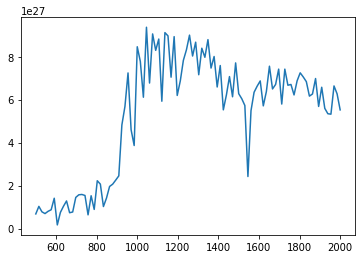

In [14]:
wavelength = np.linspace(500, 2000, 100)

L = [pop.src.L_per_sfr(l) for l in wavelength]
#L_per_sfr : [erg / s / Hz / (Msun / yr)]

pl.plot(wavelength, L)

#do I need to convert to abs Mag? and how do I know z or distance then??

In [15]:
def getParams(z):

    logM_0 = 11.88 #(0.01)
    mu = 0.019 #(0.002)
    N_0 = 0.0282 #(0.0003)
    nu = -0.72 #(0.06)
    gamma_0 = 0.556 #0.001
    gamma_1 = -0.26 #(0.05)
    beta_0 = 1.06 #(0.06)
    beta_1 = 0.17 #(0.12)

    #Redshift-dependent parameterizations
    N = N_0 * (z + 1)**nu
    M_1 = 10**(logM_0*(z+1)**mu)
    beta = beta_1*z+beta_0
    gamma = gamma_0*(z + 1)**gamma_1
    
    return N, M_1, beta, gamma

$L_{per SFR} * SFR(z, Sm) = Lum $   [erg/s/Hz]

then bin Lum --> $\phi(M_{\#})$ [mag$^{-1}$cMpc$^{-3}$]

$\frac{dM_h}{dLum} \cdot \frac{dn}{dM_h} = \phi(M_{\#})$, how to get $\frac{dM_h}{dLum}$ ??

I could get $\frac{dLum}{dM_s}$ maybe?  

Then $ \frac{dLum}{dM_s} \cdot \frac{dM_s}{dM_h} = \frac{dLum}{dM_h}$ 

In [21]:
# finite difference of Lum wrt M
def finite_dif(Lum, Sm):

    diff = []
    for i in range(len(Lum)-1):
        diff.append( (Lum[i+1] - Lum[i])/(Sm[i+1] - Sm[i]) )
    return diff

def dm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio):
    
    n2 = (-beta)*(pop_halo.halos.tab_M**(-beta-1)/M_1**(-beta)) + gamma*(pop_halo.halos.tab_M**(gamma-1)/M_1**(gamma))
    
    dydx = mM_ratio - pop_halo.halos.tab_M * 2 * N * n2 * ( (pop_halo.halos.tab_M/M_1)**(-beta) + \
                                                            (pop_halo.halos.tab_M/M_1)**(gamma) )**(-2) 

    return dydx


def dL_dM(z, Lum, Sm):
    
    N, M_1, beta, gamma = getParams(z)
    mM_ratio = np.log10( 2*N / ( (pop_halo.halos.tab_M/M_1)**(-beta) + (pop_halo.halos.tab_M/M_1)**(gamma) ) )#equ 2

    #this doesn't work as this is a very different length -  need it for only the sm values
    dmdM = dm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio)
    
    dLdm = finite_dif(Lum, Sm)
    
    return dLdm * dmdM[:-1] #this seems wrong


#same in class
def SM_fromHM(z):
    """
    Using the SMHM ratio, given a halo mass, returns the corresponding stellar mass
    """
    
    N, M_1, beta, gamma = getParams(z)
    haloMass = pop_halo.halos.tab_M

    mM_ratio = np.log10( 2*N / ( (haloMass/M_1)**(-beta) + (haloMass/M_1)**(gamma) ) ) #equ 2
#     print(mM_ratio)

    StellarMass = mM_ratio + np.log10(haloMass)

    return StellarMass

[-6.96836459 -6.94606459 -6.92376459 ... 13.84207685 13.84743377
 13.85279068]
[5.44079565e+28 5.43478842e+28 5.42878119e+28 ... 2.09771850e+28
 2.09998603e+28 2.10225356e+28]
[4.45081989e-29 4.25974069e-29 4.07687653e-29 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


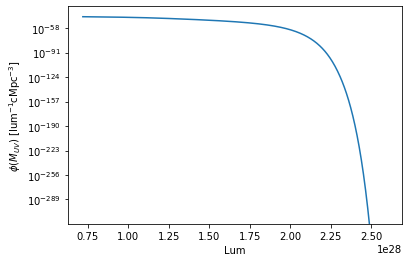

In [22]:
lamda = 1600
z = 1

# Sm = np.linspace(8, 13, 50)
Sm = SM_fromHM(z)
#cut out the super small values?
print(Sm)

mask = [m > 10.0 for m in Sm]
# print(Sm[mask])
#doesn't make a different

# [erg / s / Hz / (Msun / yr)] * (Msun)
Lum = pop.src.L_per_sfr(lamda) * pop.SFR(z, Sm)  #[erg/s/Hz]
# print(Lum)

dLdM = np.abs(dL_dM(z, Lum, Sm))
print(dLdM)

k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
dndM = pop_halo.halos.tab_dndm[k, :][:-1]
# print(dndM)

print(dndM/dLdM)

pl.semilogy((Lum[mask])[:-1], (dndM/dLdM)[mask[:-1]])
# pl.semilogy(Lum[:-1], dndM/dLdM)

pl.ylabel('$\phi(M_{UV})$ [lum$^{-1}$cMpc$^{-3}$]')
pl.xlabel('Lum')
pl.show()

[         nan          nan          nan ... -19.44075894 -19.44185277
 -19.44294549]


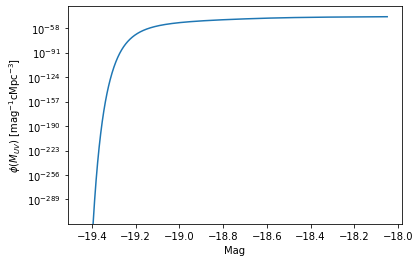

In [20]:
#sort of a weird range of mag?
MagSys = ares.util.MagnitudeSystem()
mag = MagSys.L_to_MAB(Lum, z=z)
print(mag) #all nans for z = 0


pl.semilogy((mag[mask])[:-1], (dndM/dLdM)[mask[:-1]])

# pl.semilogy(mag[:-1], dndM/dLdM)

pl.ylabel('$\phi(M_{UV})$ [mag$^{-1}$cMpc$^{-3}$]')
pl.xlabel('Mag')
pl.show()

### Quiescent galaxies  
    To start, perhaps we could parameterize this age in some simple way: 
        ○ assume that the quenching time (or redshift) is a gaussian? 
		○ Would allow us to say, for a galaxy in a halo of some mass Mh, there’s an X% probability that it quenched at redshift z. 
		○ Naturally give rise to a distribution of ages, which could be generalized to allow for an mh-dep quenching distribution.
